In [1]:
import os
print(os.getcwd())

/home/archmelow/workfolder/gaussian-splatting


In [2]:
os.path.join("./output/", "train_result","")

'./output/train_result/'

In [3]:
import numpy as np
import torch
import open3d as o3d
import sys

    
def get_frequency_map(image, patch_size) :
    # get pixel sum within patches
    patch_sum = torch.sum(
        torch.nn.functional.avg_pool2d(image, patch_size, stride=patch_size),
        dim=0
    )
    return patch_sum

def get_top_k_percent_mask(fmap, k) :
    unique_value, unique_count = torch.unique(fmap, return_counts=True)
    unique_count_accum = torch.cumsum(unique_count, dim=0)
    
    thresh_idx = (unique_count_accum < (1 - k) * unique_count_accum[-1]).sum()
    thresh_val = unique_value[thresh_idx]
    
    return fmap > thresh_val  
    
def find_guassian_within_patches(    # 2D gaussian의 평균값이 패치 안에 포함하고 있는지 판단하는 함수
    patch_size, patch_rcw_list, means2d, visibility_filter
) :
    ridx_arr, cidx_arr, width_arr = torch.tensor(patch_rcw_list).T 
    mean2d_repeat = means2d.transpose(0, 1).repeat(len(ridx_arr), 1, 1)
    return torch.any(
        (
            mean2d_repeat[:, 0, :] > cidx_arr.reshape(-1, 1) * patch_size[0]
        ) & (
            mean2d_repeat[:, 0, :] < (cidx_arr + width_arr).reshape(-1, 1) * patch_size[0]
        ) & (
            mean2d_repeat[:, 1, :] > ridx_arr.reshape(-1, 1) * patch_size[1]
        ) & (
            mean2d_repeat[:, 1, :] < (ridx_arr + 1).reshape(-1, 1) * patch_size[1]
        ),
        dim=0
    )


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [15]:

#MODEL_PATH = "gaussian-splatting/models/playroom"
#MODEL_PATH = "/home/archmelow/workfolder/gaussian-splatting/models/flowers"
MODEL_PATH = "/home/archmelow/workfolder/gaussian-splatting/models/train"


#SOURCE_PATH = "/home/archmelow/workfolder/dataset/mipnerf360/flowers"
SOURCE_PATH = "/home/archmelow/workfolder/gaussian-splatting/Data/tandt_db/tandt/train"
#SOURCE_PATH = "/home/hjp/dataset/flowers"


ITERATION = 30000

In [16]:
from argparse import ArgumentParser, Namespace
from arguments import ModelParams, PipelineParams, OptimizationParams

# necessary model params
start_from_ckpt = True

class MParams: 
    def __init__(self):
        self.source_path = SOURCE_PATH #"/home/archmelow/workfolder/gaussian-splatting/Data/tandt_db/tandt/train"
        if start_from_ckpt:
            self.add_points = False # True to add random points, False to test on original pretrained pcd points
            self.model_path = MODEL_PATH #"/home/archmelow/workfolder/gaussian-splatting/models/train"
        else:
            self.random_init_scratch = None # add random points, starting from scratch
            self.model_path = ''

        self.images = "images"

        self.sh_degree = 3
        self.resolution = -1
        self.white_background = False
        self.data_device = "cuda:0"
        self.eval = False

        self.test_iters = 7000
        self.save_iters = 7000
        self.add_points = False
# pipeline params
class PipeParams:
    def __init__(self):
        self.convert_SHs_python = False
        self.compute_cov3D_python = False
        self.debug = False

# optimizer parameters
class OptParams:
    def __init__(self):
        self.iterations = 30_000
        self.position_lr_init = 0.00016
        self.position_lr_final = 0.0000016
        self.position_lr_delay_mult = 0.01
        self.position_lr_max_steps = 30_000
        self.feature_lr = 0.0025
        self.opacity_lr = 0.05
        self.scaling_lr = 0.005
        self.rotation_lr = 0.001
        self.percent_dense = 0.01
        self.lambda_dssim = 0.2
        self.densification_interval = 100
        self.opacity_reset_interval = 3000
        self.densify_from_iter = 500
        self.densify_until_iter = 15_000
        self.densify_grad_threshold = 0.0002
        self.random_background = False


params_ = MParams()
opt_params_ = OptParams()
pipe_params_ = PipeParams()


In [17]:
print(pipe_params_)

In [18]:
from gaussian_renderer import render
import matplotlib.pyplot as plt


from scene import Scene, GaussianModel

In [19]:
device = 'cuda'

gaussians = GaussianModel(sh_degree=params_.sh_degree)  # Gaussian Model
scene = Scene(params_, gaussians, load_iteration=ITERATION)


cam = scene.getTrainCameras()[0]        # viewpoint_camera

    
bg_color = [1,1,1] if params_.white_background else [0, 0, 0]  # background color

background = torch.tensor(bg_color, dtype=torch.float32, device=device)  # background color for torch.tensor

print(gaussians._xyz.shape)


Loading trained model at iteration 30000
Reading camera 301/301
Loading Training Cameras
Loading Test Cameras
torch.Size([1026508, 3])


In [20]:
render_pkg = render(
        cam, gaussians, pipe_params_, background
    )               

image_rendered_torch = render_pkg["render"]       
'''
return {"render": rendered_image, "viewspace_points": screenspace_points,"visibility_filter" : radii > 0,  "radii": radii}
'''

f = torch.fft.fft2(image_rendered_torch, norm='ortho')   # FFT(DFT)를 수행할 때 , 변환 결과를 정규화하는 옵션 추가
fshift = torch.fft.fftshift(f).to(device)                  # 푸리에 변환결과 얻은 스펙트럼 F를 중앙으로 이동시키는(shift)

y, x = torch.meshgrid(
                torch.linspace(-1, 1, image_rendered_torch.shape[1], device=device),
                torch.linspace(-1, 1, image_rendered_torch.shape[2], device=device),
            )

cov_mat = torch.tensor(
    [[0.0005, 0],
    [0, 0.0005]],
    dtype=torch.float32,device=device
)  # covariance matrix

gs_high_filter = 1 - torch.exp(
    -torch.sum(
        torch.mul(
            torch.stack([x, y], dim=-1).view(-1, 2).transpose(0, 1),
            torch.linalg.inv(cov_mat) @ torch.stack([x, y], dim=-1).view(-1, 2).transpose(0, 1),
        ),
        axis=0
    ).view(image_rendered_torch.shape[1], image_rendered_torch.shape[2])    # High Pass Filter
)

high_freq_region = fshift * gs_high_filter

# 역푸리에변환(Inverse Fourier Transform)
ifft_tensor = torch.fft.ifft2(torch.fft.ifftshift(high_freq_region), norm='ortho').to(torch.float32)

patch_size = (8, 8)
high_freq_proportion = 0.01         # 상위 1%의 주파수 feature
frequency_map = get_frequency_map(torch.abs(ifft_tensor), patch_size)
top_k_percent_mask = get_top_k_percent_mask(frequency_map, high_freq_proportion)

high_freq_patch_ridx_list, high_freq_patch_cidx_list = np.where(top_k_percent_mask.cpu().numpy())
patch_rcw_list = [[high_freq_patch_ridx_list[0], high_freq_patch_cidx_list[0], 1]]
for ridx, cidx in zip(high_freq_patch_ridx_list, high_freq_patch_cidx_list):
    b = patch_rcw_list[-1][0]
    r = patch_rcw_list[-1][1] + patch_rcw_list[-1][2]
    if ridx == b and cidx == r:
        patch_rcw_list[-1][2] += 1
    else:
        patch_rcw_list.append([ridx, cidx, 1])



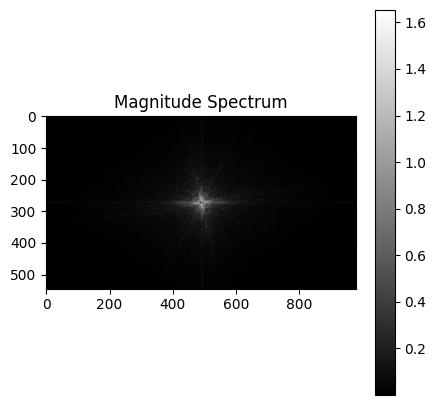

In [21]:

high_freq_region_tensor = high_freq_region

# 복소수 텐서의 크기 계산 (Magnitude)
magnitude_spectrum = torch.abs(high_freq_region_tensor)

# 여러 채널을 가진 텐서의 경우, 예를 들어 magnitude_spectrum이 [C, H, W] 형태인 경우, 채널 평균화 (혹은 첫 번째 채널 선택)
magnitude_spectrum_2d = magnitude_spectrum.mean(dim=0)  # 또는 magnitude_spectrum[0]

# 주파수 도메인 시각화
plt.figure(figsize=(5,5))
plt.imshow(torch.log(1 + magnitude_spectrum_2d).detach().cpu().numpy(), cmap='gray')
plt.title('Magnitude Spectrum')
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


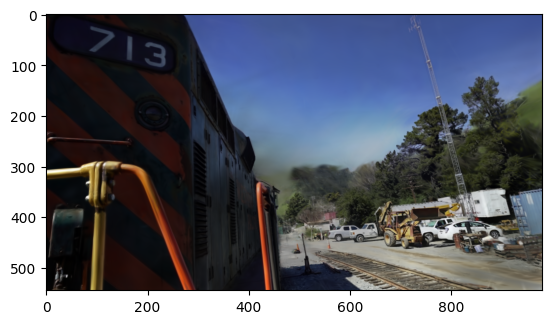

52585.37


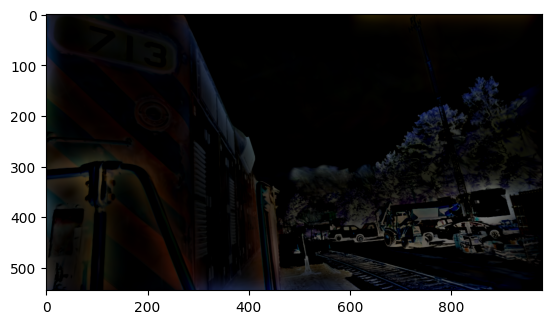

In [22]:
plt.imshow(render_pkg["render"].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

ifft_tensor_2 = ifft_tensor.clone().detach().cpu().numpy().transpose(1, 2, 0)
ifft_tensor_2[ifft_tensor_2 > 0] = 0

print(-ifft_tensor_2.sum())
plt.imshow(-ifft_tensor_2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


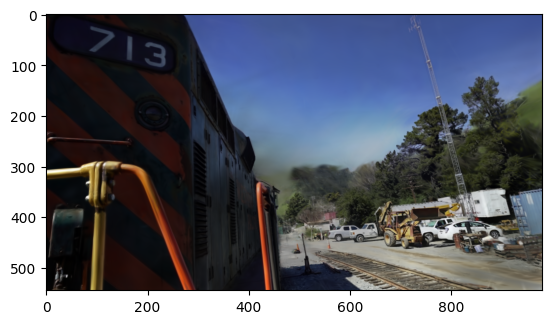

52585.37


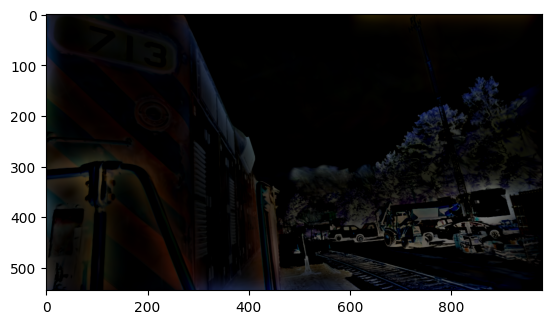

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


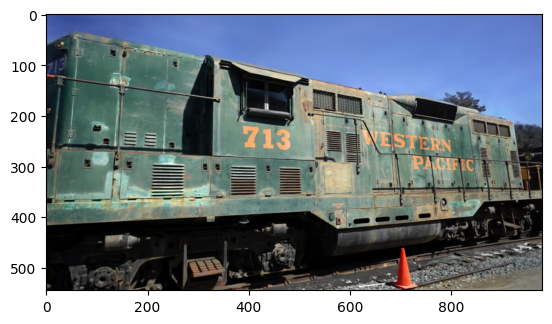

77163.3


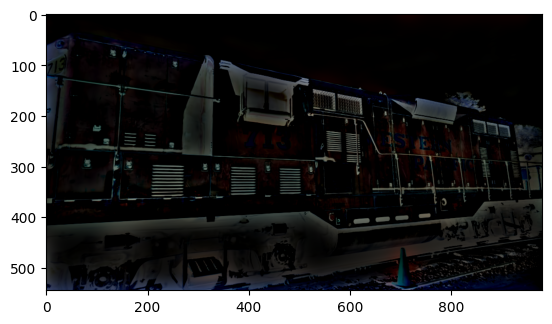

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


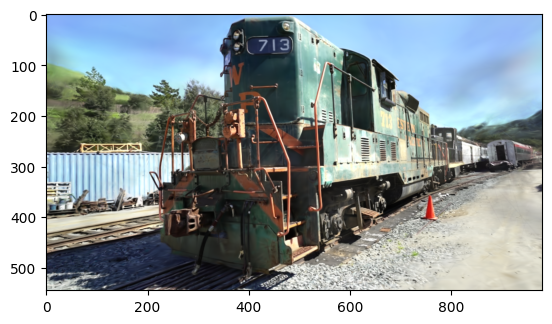

89369.54


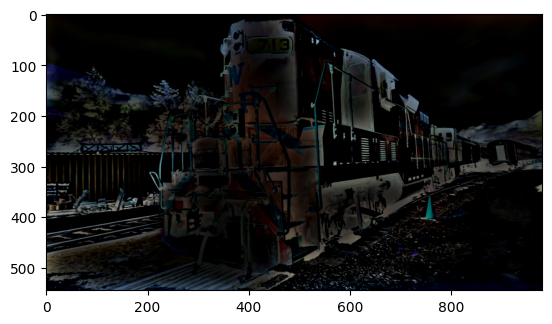

In [26]:
for i in range(3):
    render_pkg = render(
            scene.getTrainCameras()[i], gaussians, pipe_params_, background  # render(viewpoint_camera, pc : GaussianModel, pipe, bg_color : torch.Tensor, scaling_modifier = 1.0, override_color = None):
        )               

    image_rendered_torch = render_pkg["render"]       
    '''
    return {"render": rendered_image, "viewspace_points": screenspace_points,"visibility_filter" : radii > 0,  "radii": radii}
    '''

    f = torch.fft.fft2(image_rendered_torch, norm='ortho')   # FFT(DFT)를 수행할 때 , 변환 결과를 정규화하는 옵션 추가
    fshift = torch.fft.fftshift(f).to(device)                  # 푸리에 변환결과 얻은 스펙트럼 F를 중앙으로 이동시키는(shift)

    y, x = torch.meshgrid(
                    torch.linspace(-1, 1, image_rendered_torch.shape[1], device=device),
                    torch.linspace(-1, 1, image_rendered_torch.shape[2], device=device),
                )

    cov_mat = torch.tensor(
        [[0.0005, 0],
        [0, 0.0005]],
        dtype=torch.float32,device=device
    )  # covariance matrix

    gs_high_filter = 1 - torch.exp(
        -torch.sum(
            torch.mul(
                torch.stack([x, y], dim=-1).view(-1, 2).transpose(0, 1),
                torch.linalg.inv(cov_mat) @ torch.stack([x, y], dim=-1).view(-1, 2).transpose(0, 1),
            ),
            axis=0
        ).view(image_rendered_torch.shape[1], image_rendered_torch.shape[2])    # High Pass Filter
    )

    high_freq_region = fshift * gs_high_filter

    ifft_tensor = torch.fft.ifft2(torch.fft.ifftshift(high_freq_region), norm='ortho').to(torch.float32)

    patch_size = (8, 8)
    high_freq_proportion = 0.001
    frequency_map = get_frequency_map(torch.abs(ifft_tensor), patch_size)
    top_k_percent_mask = get_top_k_percent_mask(frequency_map, high_freq_proportion)

    high_freq_patch_ridx_list, high_freq_patch_cidx_list = np.where(top_k_percent_mask.cpu().numpy())
    patch_rcw_list = [[high_freq_patch_ridx_list[0], high_freq_patch_cidx_list[0], 1]]
    for ridx, cidx in zip(high_freq_patch_ridx_list, high_freq_patch_cidx_list):
        b = patch_rcw_list[-1][0]
        r = patch_rcw_list[-1][1] + patch_rcw_list[-1][2]
        if ridx == b and cidx == r:
            patch_rcw_list[-1][2] += 1
        else:
            patch_rcw_list.append([ridx, cidx, 1])
    plt.imshow(render_pkg["render"].detach().cpu().numpy().transpose(1, 2, 0))
    plt.show()

    ifft_tensor_2 = ifft_tensor.clone().detach().cpu().numpy().transpose(1, 2, 0)
    ifft_tensor_2[ifft_tensor_2 > 0] = 0

    print(-ifft_tensor_2.sum())
    plt.imshow(-ifft_tensor_2)
    plt.show()


In [24]:
frequency_map_ = frequency_map.cpu()
top_k_percent_mask_ = top_k_percent_mask.cpu()

(frequency_map_ != frequency_map.cpu()).sum(), (top_k_percent_mask_ != top_k_percent_mask.cpu()).sum()

(tensor(0), tensor(0))

In [25]:
high_freq_gaussian_mask = find_guassian_within_patches(
     patch_size, patch_rcw_list, render_pkg["means2d"], None
)

high_freq_gaussian_mask.sum(), high_freq_gaussian_mask.shape

KeyError: 'means2d'